[![License: CC BY-SA 4.0](https://img.shields.io/badge/License-CC%20BY--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-sa/4.0/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/gist/duerrsimon/965abd9bb5c46925b1d4d85bceaa9afc/trp-cage-openmm.ipynb)


# Practical: TRP Cage using OpenMM

We will use a modern and open source simulation program to run our molecular dynamics simulation of the TRP cage protein.  

OpenMM is different from most other simulations tools in that it is not controlled by executing different subprograms in the command line but instead one uses a python program to control the flow of our simulation. This allows us to easily rerun parts or the whole simulation. 

Below is a detailed description of our workflow. The respective parts you need to change during the exercise are indicated. 

## Imports

First we need to install the necessary modules and import them.  We install our simulation package openmm and parmed, which we use to load our Amber trajectory files. 


In [ ]:
# Uncomment below code on Colab

#!pip install -q condacolab
#import condacolab
#condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:33
🔁 Restarting kernel...


In [ ]:
# Uncomment on google colab 

#!conda install openmm ambertools=20 &> /dev/null  
# The last part simply makes the command silent. Remove &> /dev/null  if there are problems


Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ambertools=20
    - openmm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ambertools-20.15           |   py36h044631c_0        97.0 MB  conda-forge
    arpack-3.7.0               |       h236a147_2         212 KB  conda-forge
    boost-cpp-1.74.0           |       h9d3c048_1        16.3 MB  conda-forge
    curl-7.71.1                |       he644dc0_8         139 KB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    cython-0.29.21             |   py36hc4f0c31_2         2.2 MB  conda-forge
    freetype-2.10.4            |       h0708190_1         890 KB  conda-forge
    hdf4-4.2.13                |    h10796ff_1004         951 KB  conda

## Creating our system

Creating the system will be done using tleap which is part of the Amber software package. Linear peptides can be easily created using this tool. 

Below we create this file using python and save it as `leap.in` to the filesystem. 

Using `!cat filename` we can check whether it was sucessfully created. 

Then we execute tleap using our input file using the command `!tleap -f leap.in`. 

In [ ]:
  leapin = """source leaprc.protein.ff19SB
  set default PBradii mbondi3
  TRP = sequence {  NASN LEU TYR ILE GLN TRP LEU LYS ASP GLY GLY PRO SER SER GLY ARG PRO PRO PRO CSER}
  savepdb TRP trp_cage_linear.pdb
  saveamberparm TRP trp_cage.prmtop trp_cage_linear.nc
  quit
  """

  with open("leap.in","w+") as f:
    f.writelines(leapin)

In [ ]:
!cat leap.in

In [ ]:
!tleap -f leap.in

-I: Adding /usr/local/dat/leap/prep to search path.
-I: Adding /usr/local/dat/leap/lib to search path.
-I: Adding /usr/local/dat/leap/parm to search path.
-I: Adding /usr/local/dat/leap/cmd to search path.
-f: Source leap.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./leap.in
----- Source: /usr/local/dat/leap/cmd/leaprc.protein.ff19SB
----- Source of /usr/local/dat/leap/cmd/leaprc.protein.ff19SB done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/parm19.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA + ff19SB
Loading parameters: /usr/local/dat/leap/parm/frcmod.ff19SB
Reading force field modification type file (frcmod)
Reading title:
ff19SB AA-specific backbone CMAPs for protein 07/25/2019
Loading library: /usr/local/dat/leap/lib/amino19.lib
Loading library: /usr/local/dat/leap/lib/aminoct12.lib
Loading library: /usr/local/dat/leap/lib/aminont12.lib
Using ArgH and AspGluO modified Bondi2 radii
Writing pdb file: trp_cage_linear.p


You will be greeted with plenty output, lets go through it step by step. 

```
>$ tleap
-I: Adding /home/packages/amber20/dat/leap/prep to search path.
-I: Adding /home/packages/amber20/dat/leap/lib to search path.
-I: Adding /home/packages/amber20/dat/leap/parm to search path.
-I: Adding /home/packages/amber20/dat/leap/cmd to search path.
Welcome to LEaP!
>(no leaprc in search path)
```

This is leap starting up telling us that it has added several directories to its search path. These directories contain the parameters of the amber force field that we now will load. 

Next we need to load a specific force field. 
We do this using the following command:

```
source leaprc.protein.ff19SB
```

If you want you can take a look at this file 
you can make a new cell and use the following command: 

`!cat  /usr/local/dat/leap/parm/parm19.dat` 

Here you will find the masses, bond distance and force constants etc. that make up our forcefield. 

This produces the following output which are all force field parameters that are loaded. 

```
----- Source: /usr/local/dat/leap/cmd/leaprc.protein.ff19SB
----- Source of /usr/local/dat/leap/cmd/leaprc.protein.ff19SB done
Log file: ./leap.log
Loading parameters: /usr/local/dat/leap/parm/parm19.dat
Reading title:
PARM99 + frcmod.ff99SB + frcmod.parmbsc0 + OL3 for RNA + ff19SB
Loading parameters: /usr/local/dat/leap/parm/frcmod.ff19SB
Reading force field modification type file (frcmod)
Reading title:
ff19SB AA-specific backbone CMAPs for protein 07/25/2019
Loading library: /usr/local/dat/leap/lib/amino19.lib
Loading library: /usr/local/dat/leap/lib/aminoct12.lib
Loading library: /usr/local/dat/leap/lib/aminont12.lib
```

In the next line, we set the radii of the atoms to be used for the implicit solvation.

```
set default PBradii mbondi3
```

This produces the following line in the leap output:

```
Using ArgH and AspGluO modified Bondi2 radii
```

Next, we create a new UNIT in AMBER using the `sequence` command.

```
TRP = sequence {  NASN LEU TYR ILE GLN TRP LEU LYS ASP GLY GLY PRO SER SER GLY ARG PRO PRO PRO CSER}
```

Then, we save a PDB file of our system.

```
savepdb TRP trp_cage_linear.pdb
```

This creates the pdb file on disk and produces the following output:

```
Writing pdb file: trp_cage_linear.pdb

/usr/local/bin/teLeap: Warning!
 Converting N-terminal residue name to PDB format: NASN -> ASN

/usr/local/bin/teLeap: Warning!
 Converting C-terminal residue name to PDB format: CSER -> SER
Checking Unit.
```

As you can see, the N and C-terminal residues have a different residue namer in AMBER compared e.g to a normal serine. This is due to the fact that here the force field parameters slightly deviate from the parameters of a serine involved in two peptide bonds versus one single peptide bond for a terminal uncapped serine. 


In the last step, we now generate the parameters in AMBER format and the input coordinates in the NetCDF format (which is a binary format).

```
saveamberparm TRP trp_cage.prmtop trp_cage_linear.nc
```

This produces plenty of output and a warning:

```
/usr/local/bin/teLeap: Warning!
The unperturbed charge of the unit (1.000000) is not zero.

/usr/local/bin/teLeap: Note.
Ignoring the warning from Unit Checking.

Building topology.
Building atom parameters.
Building bond parameters.
Building angle parameters.
Building proper torsion parameters.
Building improper torsion parameters.
 total 63 improper torsions applied
Building H-Bond parameters.
Incorporating Non-Bonded adjustments.
Not Marking per-residue atom chain types.
Marking per-residue atom chain types.
  (Residues lacking connect0/connect1 - 
   these don't have chain types marked:

	res	total affected

	CSER	1
	NASN	1
  )
 (no restraints)
```

The first warning we can safely ignore as in the implicit solvent treatment we will use, we cannot use counter ions to neutralize our system. Instead we will use a screened charge model to emulate the presence of ions in the solvent. 
Next we see terms, that align with the functional form of the AMBER forcefield:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/fdc7cf40fe4d2f568921977c83e49f699d780e92)
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/7c7949ed189c2add713405eb21fe5adcbda09ca0)
![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2d244cd7f2e174af73dfc1e4dd0b37083115b690)


Again, we can look at the contents of the parameter file `!cat trp_cage.prmtop` and we see that it does not contain the coordinates anymore in contrast to the pdb file. 


## Simulating the system

Now we can start the simulation by writing our simulation script in python. 

First, lets import the required modules:

- openmm for running the simulation 
- parmed to read/write the input and output files

In [1]:
# OpenMM Imports
import simtk.openmm as mm
import simtk.openmm.app as app

# ParmEd Imports
from parmed import load_file, unit as u
from parmed.openmm import StateDataReporter, NetCDFReporter

# System modules
import sys

### Loading Amber files
In this stage, we simply instantiate the AmberParm object from the input topology and coordinate files. After this command, `trp_cage_gas` will contain a full description of every particle, the parameters defining their interactions, and their position.

In [7]:
# Load the Amber files
print('Loading AMBER files...')
trp_cage_gas = load_file('trp_cage.prmtop', 'trp_cage_linear.nc')


Loading AMBER files...


### Create the OpenMM System

This command creates an OpenMM ``System`` object from the information stored in
``trp_cage_gas``. It contains multiple ``Force`` instances for the bonds, angles,
periodic torsions, and nonbonded (electrostatic and van der Waals) interactions.
It is in this function that we define the potential parameters we want to use.
In this example, we have chosen the default values for each parameter except the
ones specified. In particular:

- `nonbondedMethod=app.NoCutoff` indicates we do not want to use a cutoff for nonbonded interactions. 
- `constraints=app.HBonds` indicates we want to constrain all bonds in which at least one atom is a Hydrogen (i.e., SHAKE or SETTLE for water).  Other options are `None` (no constraints), `app.AllBonds`, or `app.HAngles`. 
- `implicitSolvent=app.GBn2` indicates we want to use the second GBneck model described in Nguyen et al., J. Chem. Theory Comput., 2014 9(4) p.2020-2034. 
- `implicitSolventSaltConc=0.1*u.liters/u.mole` indicates we want to model a ca. 0.1 molar solution of monovalent ions using a Debye screening model.

In [8]:
# Create the OpenMM system
print('Creating OpenMM System')
system = trp_cage_gas.createSystem(nonbondedMethod=app.NoCutoff,
                               constraints=app.HBonds, implicitSolvent=app.GBn2,
                               implicitSolventSaltConc=0.1*u.moles/u.liter,
)

Creating OpenMM System


### Create the integrator to do Langevin Dynamics


In this stage we specify an integrator. Common choices are
``LangevinIntegrator`` (as we've chosen here) to do simulations in the NVT
ensemble.  In this
example, we've chosen the Langevin integrator with a target temperature of
300 K, a friction coefficient of 1/ps and a time step of 0.5 fs.

In [9]:
# Create the integrator to do Langevin dynamics
integrator = mm.LangevinIntegrator(
                        0*u.kelvin,       # Temperature of heat bath
                        1.0/u.picoseconds,  # Friction coefficient
                        0.5*u.femtoseconds, # Time step
)


### Create the ``Simulation`` object

This step creates a ``Simulation`` object that will be used to run the actual
simulations.  OpenMM picks the fastest platform for us
if we do not specify a platform.

In [10]:
# Create the Simulation object
sim = app.Simulation(trp_cage_gas.topology, system, integrator,)

This stage is very important.  In this step, we set the particle positions
stored in the ``trp_cage_gas`` object to our object. If you omit this step, you can
get strange results or other errors like segmentation violations. These particle
positions have been parsed from the input coordinate file.


In [11]:
# Set the particle positions
sim.context.setPositions(trp_cage_gas.positions)

### Minimize the energy

This stage performs a basic energy minimization to relax particle positions.
This particular invocation will perform at most 500 iterations.

In [12]:

# Minimize the energy
print('Minimizing energy')
sim.minimizeEnergy(maxIterations=500)

state = sim.context.getState(getEnergy=True)
print(state.getPotentialEnergy())

Minimizing energy
-3093.022096958216 kJ/mol


### Heating phase

After having obtained the minimized coordinates of our system we can begin slowly heating it. 
We define reporters that will "report" on the status of the simulation
periodically throughout the heating phase. The first is a ``StateDataReporter``
which will print out a summary of energies and temperatures every 500 steps.
This reporter directs the printout to standard output (the screen), ``sys.stdout`` or to a file name (if set).

The second reporter is a NetCDF trajectory reporter, which is written in the
Amber NetCDF format. 

In [13]:
print('Heating phase')
sim.reporters.append(StateDataReporter('heating.csv', 500, step=True, potentialEnergy=True,  kineticEnergy=True, temperature=True)
 )
sim.reporters.append(
         NetCDFReporter('trp_cage_heating.nc', 500, crds=True)
)

for i in range(5):
    integrator.setTemperature(65*(i+1)*u.kelvin)
    sim.step(500)  ## Change this in order to run 50 ps of heating in 5 steps

state = sim.context.getState(getPositions=True)
minimized_and_heated=state.getPositions()

Heating phase


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

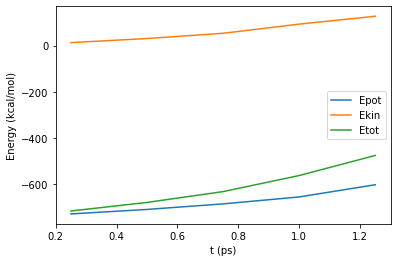

In [15]:
df=pd.read_csv('heating.csv')

fig, ax = plt.subplots(1)

ax.plot(df['Time (ps)'],df['Potential Energy (kilocalorie/mole)'], label='Epot')
ax.plot(df['Time (ps)'],df['Kinetic Energy (kilocalorie/mole)'], label='Ekin')
ax.plot(df['Time (ps)'],df['Total Energy (kilocalorie/mole)'], label='Etot')
ax.set_xlabel('t (ps)')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()
plt.show()

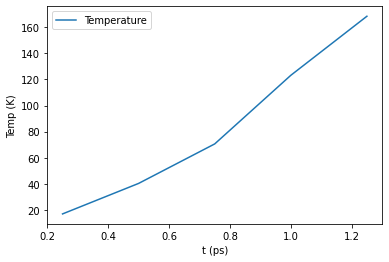

In [16]:
fig, ax = plt.subplots(1)

ax.plot(df['Time (ps)'],df['Temperature (K)'], label='Temperature')
ax.set_xlabel('t (ps)')
ax.set_ylabel('Temp (K)')
ax.legend()
plt.show()

## Running dynamics

We first reset our Integrator to update the timestep, create the simulation object and then we actually run the MD of our heated system to see if our linear peptide folds up into its 3D form. We use again the `NetCDF` and `StateDataReporter` to retrieve information about our simulation. 

In [17]:
# Create the integrator to do Langevin dynamics
integrator = mm.LangevinIntegrator(
                        325*u.kelvin,       # Temperature of heat bath
                        1.0/u.picoseconds,  # Friction coefficient
                        2.0*u.femtoseconds, # Time step
)

# Create the Simulation object
sim = app.Simulation(trp_cage_gas.topology, system, integrator)

# Set the particle positions
sim.context.setPositions(minimized_and_heated)

# Set up the reporters to report energies and coordinates every 50000 steps
sim.reporters.append(
        StateDataReporter('production.csv', 50000, step=True, potentialEnergy=True,
                               kineticEnergy=True, temperature=True)
)
# Additionally print to the output of the notebook, so that we can track the simulation.
sim.reporters.append(
        StateDataReporter(sys.stdout, 50000, step=True, potentialEnergy=True,
                               kineticEnergy=True, temperature=True)
)
sim.reporters.append(
        NetCDFReporter('trp_cage_gb.nc', 50000, crds=True)
)

# Run dynamics
print('Running dynamics')
sim.step(1) # change this to run 20 ns of simulation



Running dynamics


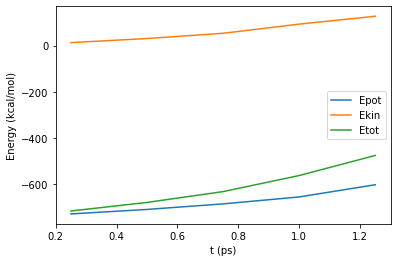

In [18]:
# Plotting energy from production simulation

df=pd.read_csv('production.csv')

fig, ax = plt.subplots(1)

ax.plot(df['Time (ps)'],df['Potential Energy (kilocalorie/mole)'], label='Epot')
ax.plot(df['Time (ps)'],df['Kinetic Energy (kilocalorie/mole)'], label='Ekin')
ax.plot(df['Time (ps)'],df['Total Energy (kilocalorie/mole)'], label='Etot')
ax.set_xlabel('t (ps)')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()
plt.show()

In [19]:
print('Average temperature')
print(f"{np.mean(df['Temperature (K)']):.3f} +- {np.std(df['Temperature (K)']):.3f} ")

Average temperature
83.891 +- 55.240 


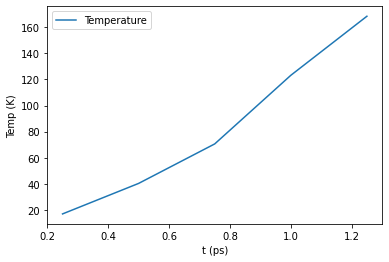

In [20]:
fig, ax = plt.subplots(1)

ax.plot(df['Time (ps)'],df['Temperature (K)'], label='Temperature')
ax.set_xlabel('t (ps)')
ax.set_ylabel('Temp (K)')
ax.legend()
plt.show()